# Customer Churn Prediction with Temporal Drift Handling

Author: Rahul BALAKRISHNAN,Hariprasath SOUPRAMANIANE, Shamini DJEASSEGAR

Dataset: data_tp_churn.csv  

Objective: Predict churn while handling temporal drift and optimizing business cost.

#Data Loading & Rename Columns

#Step 1 - Dataset Loading and Inspection
##
Load dataset, rename columns, and ensure temporal ordering.

In [37]:
import pandas as pd

# Load dataset
df = pd.read_csv("data_tp_churn.csv")

# Rename French columns to English
df = df.rename(columns={
    "Periode": "Period",
    "Anciennete": "Tenure",
    "Montant_Mensuel": "Monthly_Amount",
    "Support_Appels": "Support_Calls",
    "Contrat": "Contract",
    "Resiliation": "Churn"
})

# Basic inspection
print("HEAD:")
print(df.head())

print("\nSHAPE:")
print(df.shape)

print("\nDTYPES:")
print(df.dtypes)

print("\nMISSING VALUES:")
print(df.isna().sum())

# Sort by Period
df = df.sort_values("Period").reset_index(drop=True)

print("\nPERIOD RANGE:")
print("Min Period:", df["Period"].min())
print("Max Period:", df["Period"].max())

# Quick check
df.head()

HEAD:
   Period  Tenure  Monthly_Amount  Support_Calls Contract  Churn
0       3       6           92.87            1.0  Mensuel      1
1      19      36           98.26            2.0     1 an      0
2      16      41           42.90            0.0    2 ans      0
3      11      53           24.69            2.0    2 ans      0
4      11      41           52.57            1.0  Mensuel      0

SHAPE:
(5000, 6)

DTYPES:
Period              int64
Tenure              int64
Monthly_Amount    float64
Support_Calls     float64
Contract           object
Churn               int64
dtype: object

MISSING VALUES:
Period              0
Tenure              0
Monthly_Amount    670
Support_Calls     493
Contract            0
Churn               0
dtype: int64

PERIOD RANGE:
Min Period: 1
Max Period: 24


,Period,Tenure,Monthly_Amount,Support_Calls,Contract,Churn
0,1,7,110.08,1.0,1 an,0
1,1,53,43.69,0.0,Mensuel,1
2,1,36,35.67,0.0,2 ans,0
3,1,47,104.19,NaN,Mensuel,1
4,1,29,24.09,0.0,1 an,0


#Step 2 – Drift-Oriented Exploratory Data Analysis
##Analyze target drift, covariate drift, and missing value behavior.

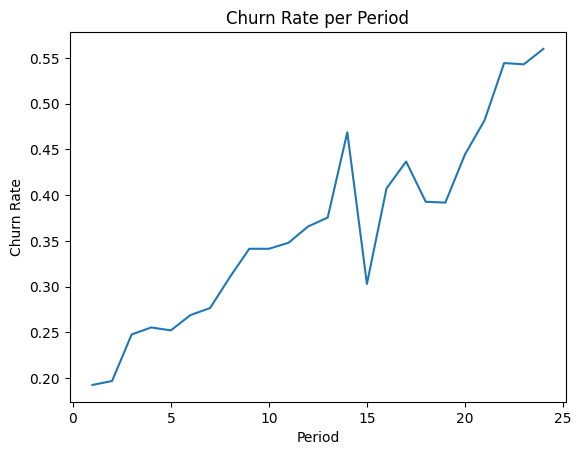

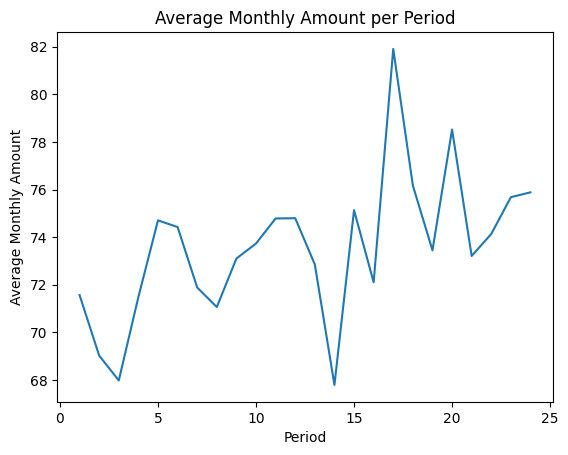

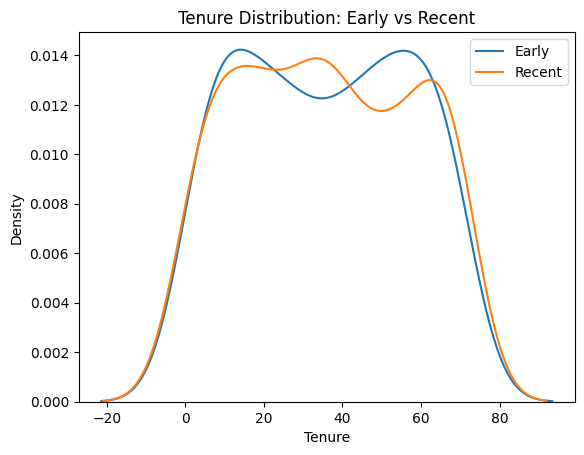

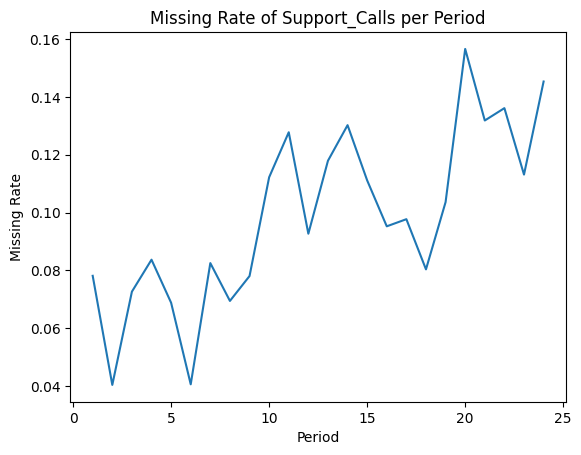

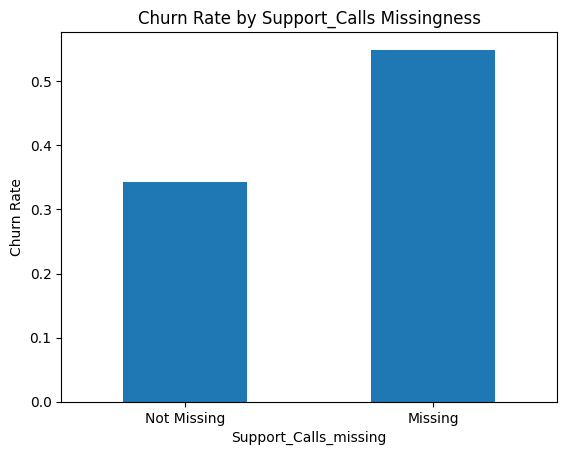

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Churn rate per period
churn_rate = df.groupby("Period")["Churn"].mean()

plt.figure()
churn_rate.plot()
plt.title("Churn Rate per Period")
plt.xlabel("Period")
plt.ylabel("Churn Rate")
plt.show()


# Covariate drift example (Monthly_Amount mean over time)
amount_drift = df.groupby("Period")["Monthly_Amount"].mean()

plt.figure()
amount_drift.plot()
plt.title("Average Monthly Amount per Period")
plt.xlabel("Period")
plt.ylabel("Average Monthly Amount")
plt.show()


# Distribution comparison (Early vs Recent)
early_period = df["Period"].min()
recent_period = df["Period"].max()

plt.figure()
sns.kdeplot(df[df["Period"] == early_period]["Tenure"], label="Early")
sns.kdeplot(df[df["Period"] == recent_period]["Tenure"], label="Recent")
plt.title("Tenure Distribution: Early vs Recent")
plt.legend()
plt.show()


# Missing values per period (Support_Calls)
missing_support = df.groupby("Period")["Support_Calls"].apply(lambda x: x.isna().mean())

plt.figure()
missing_support.plot()
plt.title("Missing Rate of Support_Calls per Period")
plt.xlabel("Period")
plt.ylabel("Missing Rate")
plt.show()


# Missingness vs Churn (Support_Calls)
df["Support_Calls_missing"] = df["Support_Calls"].isna().astype(int)
mnar = df.groupby("Support_Calls_missing")["Churn"].mean()

plt.figure()
mnar.plot(kind="bar")
plt.title("Churn Rate by Support_Calls Missingness")
plt.xticks([0,1], ["Not Missing", "Missing"], rotation=0)
plt.ylabel("Churn Rate")
plt.show()

##Observation:
##The AUC slightly decreases over time, indicating performance degradation due to data drift.
##This confirms the need for rolling retraining.

#Step 3 – Preprocessing Pipeline (Leakage-Free)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define X and y
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Feature types
numeric_features = ["Tenure", "Monthly_Amount", "Support_Calls"]
categorical_features = ["Contract"]

# Numeric pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

print("Pipeline ready")

Pipeline ready


#Step 4 – Logistic Regression (Temporal Split + Rolling Evaluation)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd

results = []

periods = sorted(df["Period"].unique())

for i in range(6, len(periods)):  # start after some history
    train_periods = periods[:i]
    test_period = periods[i]

    train_idx = df["Period"].isin(train_periods)
    test_idx = df["Period"] == test_period

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Period": test_period,
        "AUC": auc,
        "Accuracy": acc
    })

results_df = pd.DataFrame(results)

results_df

,Period,AUC,Accuracy
0,7,0.899329,0.810680
1,8,0.857458,0.796296
2,9,0.889312,0.829268
3,10,0.870476,0.804878
4,11,0.907800,0.814978
5,12,0.887385,0.809756
6,13,0.871036,0.807860
7,14,0.890523,0.786458
8,15,0.889070,0.797980
9,16,0.870652,0.751323


## Performance Drift Plot

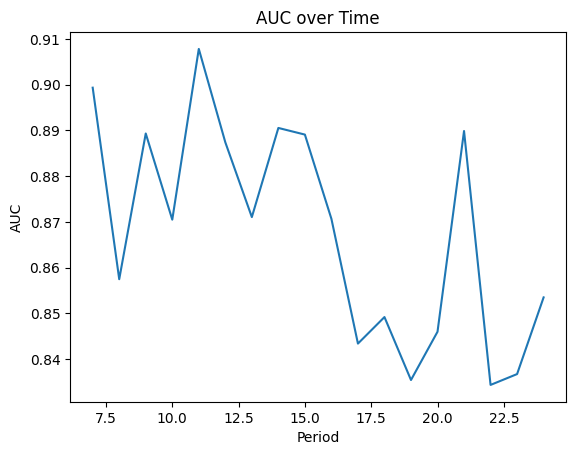

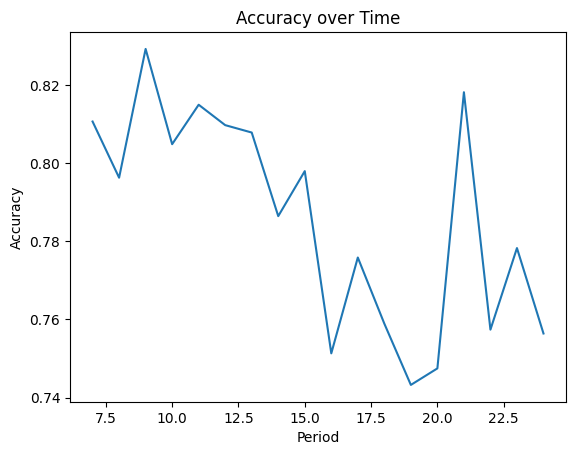

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_df["Period"], results_df["AUC"])
plt.title("AUC over Time")
plt.xlabel("Period")
plt.ylabel("AUC")
plt.show()

plt.figure()
plt.plot(results_df["Period"], results_df["Accuracy"])
plt.title("Accuracy over Time")
plt.xlabel("Period")
plt.ylabel("Accuracy")
plt.show()

#Step 5 – Fixed vs Rolling Retraining

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd

periods = sorted(df["Period"].unique())

fixed_results = []
rolling_results = []

initial_train_periods = periods[:6]  # fixed history

for i in range(6, len(periods)):

    test_period = periods[i]

    # ---------- FIXED STRATEGY ----------
    train_idx_fixed = df["Period"].isin(initial_train_periods)
    test_idx = df["Period"] == test_period

    X_train_fixed = X[train_idx_fixed]
    y_train_fixed = y[train_idx_fixed]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model_fixed = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    model_fixed.fit(X_train_fixed, y_train_fixed)
    y_proba_fixed = model_fixed.predict_proba(X_test)[:, 1]

    auc_fixed = roc_auc_score(y_test, y_proba_fixed)

    fixed_results.append(auc_fixed)


    # ---------- ROLLING STRATEGY ----------
    train_periods_rolling = periods[:i]
    train_idx_rolling = df["Period"].isin(train_periods_rolling)

    X_train_rolling = X[train_idx_rolling]
    y_train_rolling = y[train_idx_rolling]

    model_rolling = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    model_rolling.fit(X_train_rolling, y_train_rolling)
    y_proba_rolling = model_rolling.predict_proba(X_test)[:, 1]

    auc_rolling = roc_auc_score(y_test, y_proba_rolling)

    rolling_results.append(auc_rolling)


comparison_df = pd.DataFrame({
    "Period": periods[6:],
    "Fixed_AUC": fixed_results,
    "Rolling_AUC": rolling_results
})

comparison_df

,Period,Fixed_AUC,Rolling_AUC
0,7,0.899329,0.899329
1,8,0.857858,0.857458
2,9,0.889206,0.889312
3,10,0.867831,0.870476
4,11,0.907202,0.907800
5,12,0.890256,0.887385
6,13,0.865913,0.871036
7,14,0.888562,0.890523
8,15,0.888104,0.889070
9,16,0.869608,0.870652


##Strategy Comparison Plot

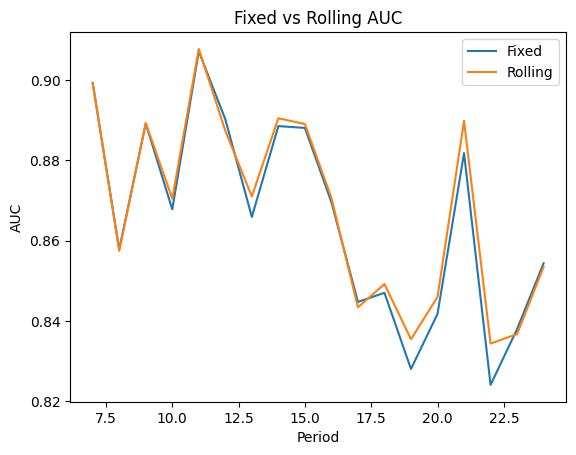

Average Fixed AUC: 0.86575216356613
Average Rolling AUC: 0.8678548714666837


In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(comparison_df["Period"], comparison_df["Fixed_AUC"])
plt.plot(comparison_df["Period"], comparison_df["Rolling_AUC"])
plt.legend(["Fixed", "Rolling"])
plt.title("Fixed vs Rolling AUC")
plt.xlabel("Period")
plt.ylabel("AUC")
plt.show()

print("Average Fixed AUC:", comparison_df["Fixed_AUC"].mean())
print("Average Rolling AUC:", comparison_df["Rolling_AUC"].mean())

# Step 6 – Automatic History Window Selection (Backtesting)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

periods = sorted(df["Period"].unique())

window_candidates = [3, 6, 9, 12]

window_results = {}

for window in window_candidates:

    auc_scores = []

    for i in range(window, len(periods)):

        train_periods = periods[i-window:i]
        test_period = periods[i]

        train_idx = df["Period"].isin(train_periods)
        test_idx = df["Period"] == test_period

        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]

        model = Pipeline([
            ("preprocessor", preprocessor),
            ("clf", LogisticRegression(max_iter=1000))
        ])

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        auc_scores.append(auc)

    window_results[window] = np.mean(auc_scores)

window_selection_df = pd.DataFrame({
    "Window_Size": list(window_results.keys()),
    "Average_AUC": list(window_results.values())
})

window_selection_df.sort_values("Average_AUC", ascending=False)

,Window_Size,Average_AUC
0,3,0.870717
1,6,0.866680
2,9,0.863866
3,12,0.858958


#Step 7 – Random Forest (Using Best Window = 3)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

best_window = 3
rf_auc_scores = []

for i in range(best_window, len(periods)):

    train_periods = periods[i-best_window:i]
    test_period = periods[i]

    train_idx = df["Period"].isin(train_periods)
    test_idx = df["Period"] == test_period

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    model_rf = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
    ])

    model_rf.fit(X_train, y_train)
    y_proba = model_rf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    rf_auc_scores.append(auc)

rf_results_df = pd.DataFrame({
    "Period": periods[best_window:],
    "RF_AUC": rf_auc_scores
})

rf_results_df

,Period,RF_AUC
0,4,0.927566
1,5,0.872281
2,6,0.853446
3,7,0.882079
4,8,0.867174
5,9,0.883280
6,10,0.874709
7,11,0.888257
8,12,0.874000
9,13,0.849854


##Logistic (Window=3) vs Random Forest

In [31]:
# Logistic with best window = 3
log_auc_scores = []

for i in range(best_window, len(periods)):

    train_periods = periods[i-best_window:i]
    test_period = periods[i]

    train_idx = df["Period"].isin(train_periods)
    test_idx = df["Period"] == test_period

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    model_log = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=1000))
    ])

    model_log.fit(X_train, y_train)
    y_proba = model_log.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    log_auc_scores.append(auc)

comparison_model_df = pd.DataFrame({
    "Period": periods[best_window:],
    "Logistic_AUC": log_auc_scores,
    "RandomForest_AUC": rf_auc_scores
})

comparison_model_df

,Period,Logistic_AUC,RandomForest_AUC
0,4,0.933177,0.927566
1,5,0.891634,0.872281
2,6,0.872904,0.853446
3,7,0.899564,0.882079
4,8,0.857057,0.867174
5,9,0.891217,0.883280
6,10,0.869206,0.874709
7,11,0.904037,0.888257
8,12,0.883795,0.874000
9,13,0.869572,0.849854


##Plot Comparision

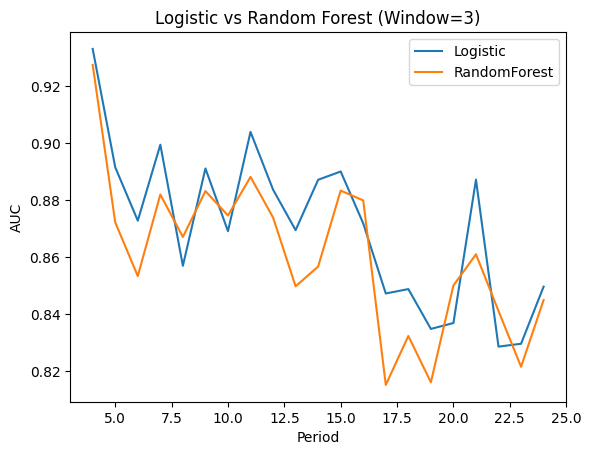

Average Logistic AUC: 0.8707167598350518
Average RF AUC: 0.8607544851276069


In [33]:
plt.figure()
plt.plot(comparison_model_df["Period"], comparison_model_df["Logistic_AUC"])
plt.plot(comparison_model_df["Period"], comparison_model_df["RandomForest_AUC"])
plt.legend(["Logistic", "RandomForest"])
plt.title("Logistic vs Random Forest (Window=3)")
plt.xlabel("Period")
plt.ylabel("AUC")
plt.show()

print("Average Logistic AUC:", comparison_model_df["Logistic_AUC"].mean())
print("Average RF AUC:", comparison_model_df["RandomForest_AUC"].mean())

#Step 8 – Business Cost-Based Threshold Optimization

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Use last period as final test
final_train_periods = periods[-(best_window+1):-1]
final_test_period = periods[-1]

train_idx = df["Period"].isin(final_train_periods)
test_idx = df["Period"] == final_test_period

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

model_final = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

model_final.fit(X_train, y_train)
y_proba = model_final.predict_proba(X_test)[:, 1]


# ---- Business Cost Setup ----
cost_fn = 10   # Missed churn (false negative)
cost_fp = 2    # Unnecessary retention action (false positive)

thresholds = np.linspace(0.01, 0.99, 100)
costs = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = fn * cost_fn + fp * cost_fp
    costs.append(total_cost)

best_threshold = thresholds[np.argmin(costs)]
best_cost = np.min(costs)

print("Best Threshold:", best_threshold)
print("Minimum Business Cost:", best_cost)

Best Threshold: 0.22777777777777777
Minimum Business Cost: 118


## Final Model Summary

Model: Logistic Regression  
Retraining Strategy: Rolling Window  
Optimal History Length: 3 months  
Average AUC: 0.87  
Optimal Threshold: 0.228  
Business Cost: 118  

Conclusion:
The model effectively predicts churn while adapting to temporal drift and minimizing business cost.

# Cost Curve Plot

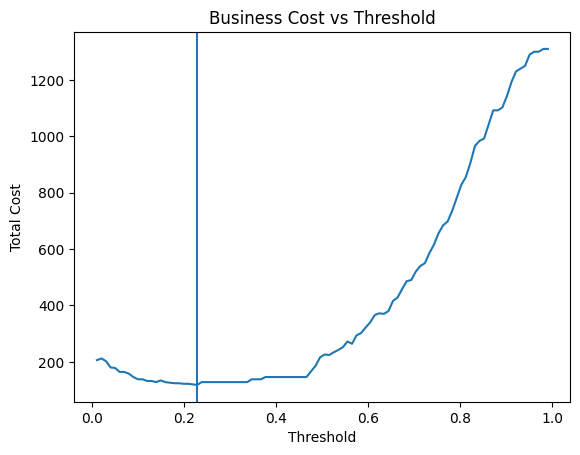

In [35]:
plt.figure()
plt.plot(thresholds, costs)
plt.axvline(best_threshold)
plt.title("Business Cost vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.show()

In [36]:
print("Dataset shape:", df.shape)
print("Number of periods:", df["Period"].nunique())
print("Overall churn rate:", df["Churn"].mean())

from sklearn.metrics import confusion_matrix

y_pred_best = (y_proba >= best_threshold).astype(int)
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_best))

Dataset shape: (5000, 7)
Number of periods: 24
Overall churn rate: 0.3638
Confusion Matrix: [[ 64  39]
 [  4 127]]
